# Predicting job change

## Project definition

### Overview

- A company that relies on Big Data wants to hire data scientists among candidates that sign up for a special training they provide. 
- The objetive is to predict the probability that an enrollee will want to work for the company after the training or will start looking for a new job.
- This information is useful for the company as it helps to plan training courses as to reduce the cost and time and control for the quality of sessions.
- Current credentials, demographics and experience data is provided for each enrollee, as well as a target variable that indicates wether a candidate is not looking for a new job (0) or is looking for a job (1).
- The dataset comes from [Kaggle](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists).

### Features

- `enrollee_id:` Unique ID for candidate
- `city:` City code
- `city_development_index:` Developement index of the city (scaled)
- `gender:` Gender of candidate
- `relevent_experience:` Relevant experience of candidate
- `enrolled_university:` Type of University course enrolled if any
- `education_level:` Education level of candidate
- `major_discipline:` Education major discipline of candidate
- `experience:` Candidate total experience in years
- `company_size:` No of employees in current employer's company
- `company_type:` Type of current employer
- `lastnewjob:` Difference in years between previous job and current job
- `training_hours:` training hours completed
- `target:` 0 – Not looking for job change, 1 – Looking for a job change

### Problem

- Estimate the probability that a candidate will start looking for a new job after the training.

### Metrics

- The model evaluation metric will be the [Area Under the Receiver Operating Characteristic Curve (ROC AUC)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

## Exploratory Data Analysis (EDA) of raw data

In [16]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *

A train and test set have been provided, the test data has no target info. In this section we will explore relevant charateristics of the data.

- **Shape of train and test sets:**

In [19]:
# Load raw data
train = pd.read_csv("data/aug_train.csv")
test = pd.read_csv("data/aug_test.csv")
print("Train shape: " + str(train.shape[0]) + " rows, and " +  str(train.shape[1]) + " columns")
print("Test shape: " + str(test.shape[0]) + " rows, and " +  str(test.shape[1]) + " columns")

Train shape: 19158 rows, and 14 columns
Test shape: 2129 rows, and 13 columns


As mentioned the test set is missing the target field.

### Fields and data types

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

### Number of unique enrollees by dataset

In [48]:
print("Unique enrollees in train dataset: " + str(len(train.enrollee_id.unique())))
print("Unique enrollees in test dataset: " + str(len(test.enrollee_id.unique())))

Unique enrollees in train dataset: 19158
Unique enrollees in test dataset: 2129


10 out of 14 fields are categorical and the reamining 4 are numerical.

### Target descriptions

In [77]:
df_target_counts = train[['target']].value_counts().reset_index().rename(columns = {0: 'counts'})
df_target_counts['target'] = df_target_counts.target.astype('object')
df_target_counts['percent'] = train.target.value_counts(normalize=True).round(2).mul(100)
df_target_counts

,target,counts,percent
0,0,14381,75.0
1,1,4777,25.0


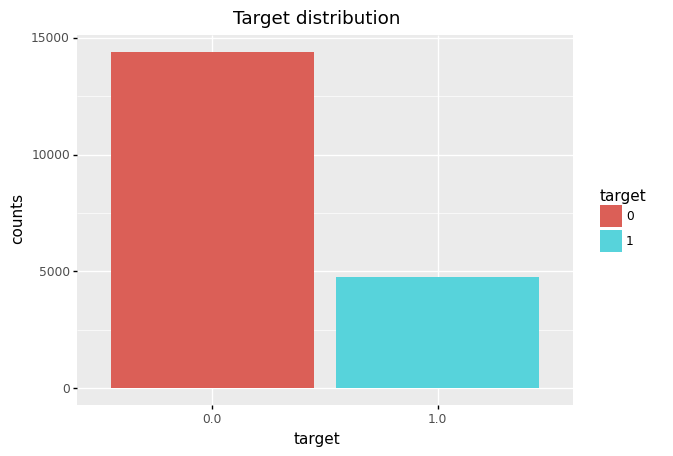

<ggplot: (324652813)>

In [79]:
( 
    ggplot( df_target_counts, aes(x = 'target', y = 'counts', fill = 'target') ) + 
    geom_col() +
    labs(title =  "Target distribution")
)

It is a highly impalanced target, for each enrollee that wants to lookg for a new job, there are three that are staying.

### Missing values

In [102]:
df_train_missing_vals = train.isna().sum().reset_index().rename( columns = {'index': 'fields', 0: 'counts'}).sort_values(by = 'counts', ascending = False)
df_train_missing_vals['percent'] = round(df_train_missing_vals.counts / train.shape[0], 2)*100
df_train_missing_vals

,fields,counts,percent
10,company_type,6140,32.0
9,company_size,5938,31.0
3,gender,4508,24.0
7,major_discipline,2813,15.0
6,education_level,460,2.0
11,last_new_job,423,2.0
5,enrolled_university,386,2.0
8,experience,65,0.0
0,enrollee_id,0,0.0
1,city,0,0.0


There are missing values in the dataset. The fields company_type, company_size, gender and major_discipline are the fields that have more than 15% of their values missing. 

Education_level, enrolled_university and last_new_job have only 2% values missing.

An imputation strategy should be used such as the mode or trying aggregate them in others category.

### Visualizations

In [103]:
def plot_categorical_fields(df, variable):
    df = df.assign(counts = 1)
    df[variable] = df[variable].fillna("Missing")
    df.groupby([variable, 'target'])['counts'].sum()
    df = pd.DataFrame(df).reset_index()
    df['target'] = df.target.astype('category')
    gg = (
        ggplot( df, aes( x = variable, y = 'counts', fill = 'target') ) +
        geom_col() +
        labs( title = 'Target vs: ' + variable)
    )
    gg.draw()

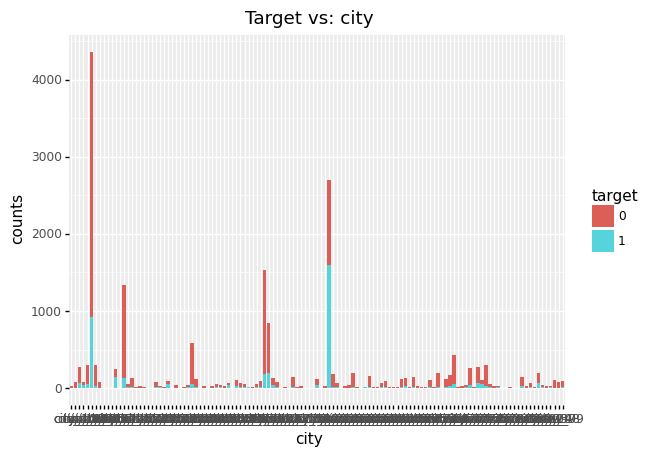

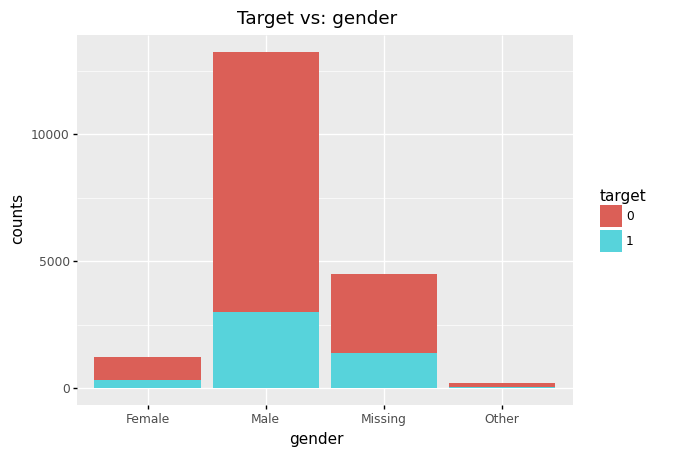

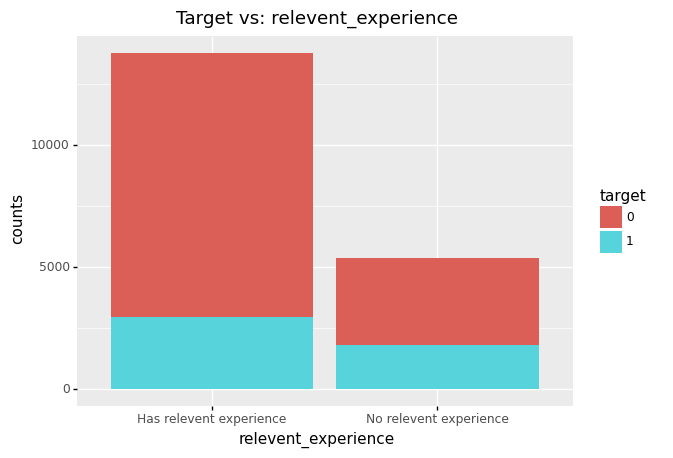

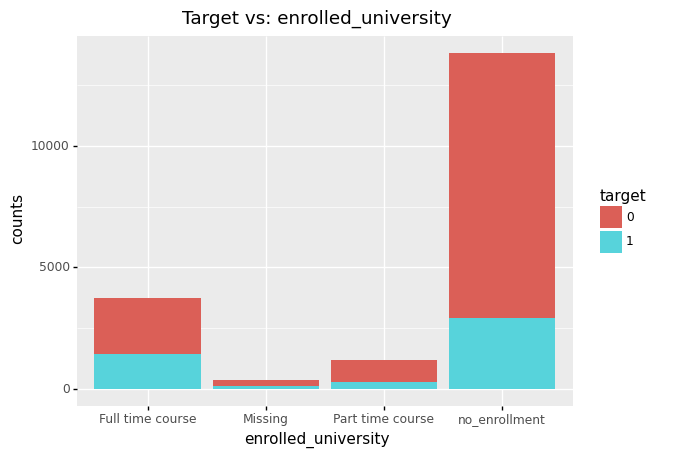

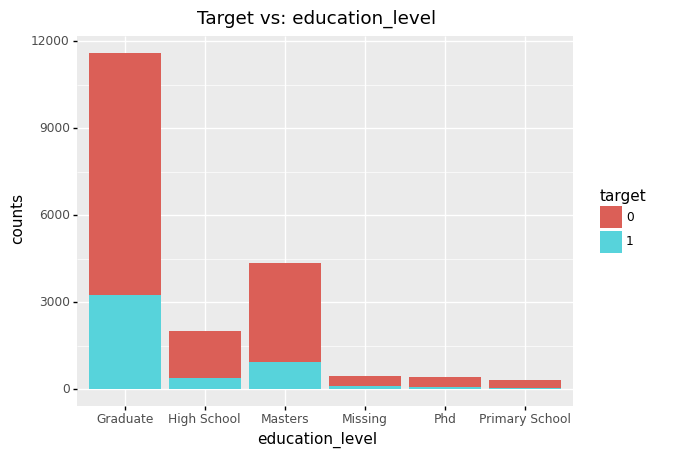

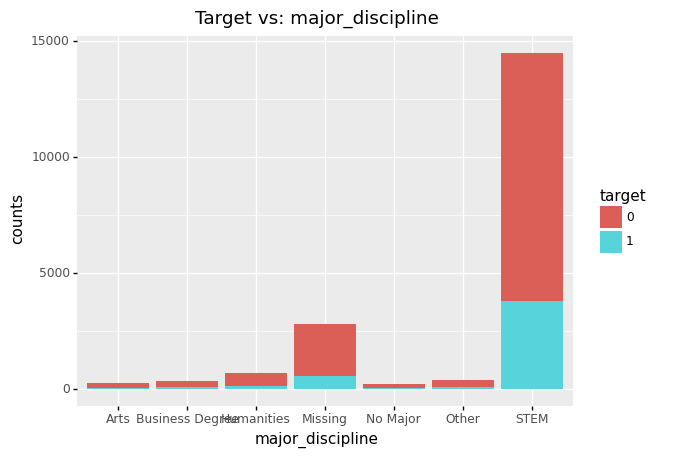

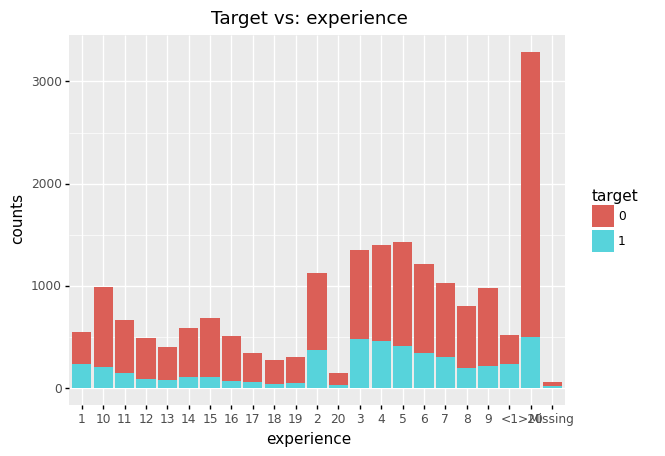

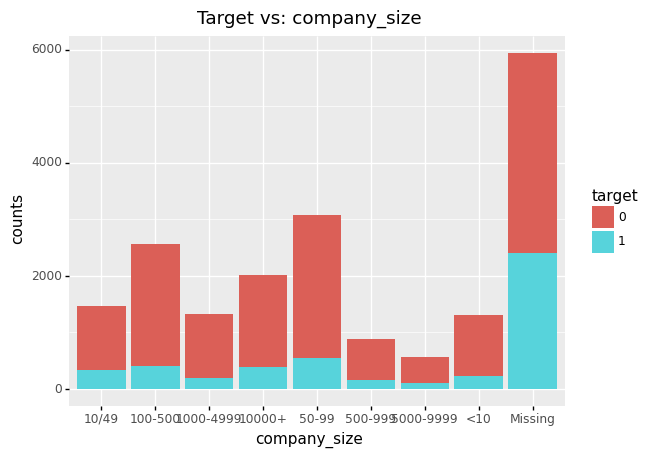

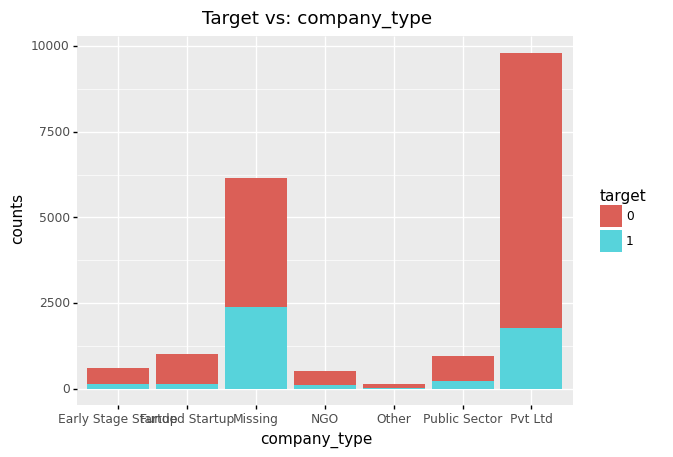

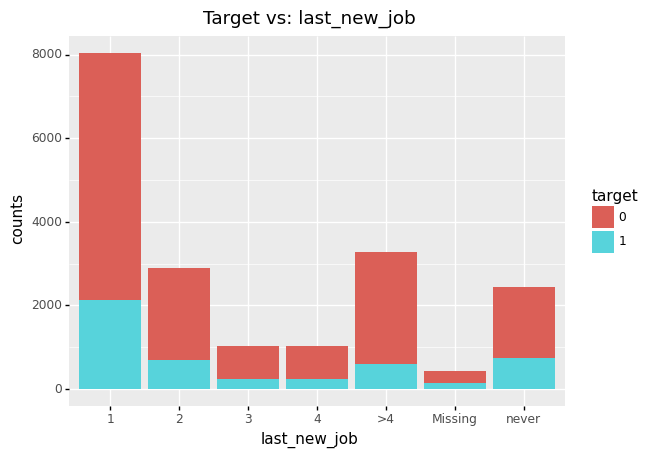

In [104]:
for field in train.dtypes[(train.dtypes == 'object') | (train.dtypes == 'category') ].index:
    plot_categorical_fields(train, field)

### A few observations by fields:

- `city:` It is very hetrogeneous, there are 6 cities with more observations than others.
- `gender:` There are more males than females, but also missing genders is high enough. Missing genders could be aggregated with others.
- `relevant_experience:` There is people with more relevant experience than others, but in terms of who wants to stay and who wants to leave there is no clear pattern.
- `enrolled_university:` There are more enrollees not enrolled in university, I will assume they are professionals. Missing values can be aggregated to no_enrollment.
- `eductaion_level:` Most of the enrollees are graduates and have a postgraduate. There are many other education levels that could be aggregated to have more general categories.
- `major_discipline:` Most enrollee come from STEM major disciplines. The rest show very few records. Major disciplines could be aggregated into more general ones.
- `experience:` There are more enrollees with less than or equal to 9 years of experience than with more than 9 years of experience. It is more likely that people with less years of experience choose to look for a new job. This variable could also be aggregated into more general values.
- `company_type:` Most of the enrollees work for private sector, however the number of records with missing data are too many. Missing and other company type could be aggregated. The rest of the types could be aggregated into more general ones.
- `company_size:` Most other enrollee did not indicate company size, they could be aggregated into the less than 10 category. This field is a bit dirty; it could be aggregated into more general categories. Apparently, enrollees with missing values tend to look for a new job.
- `last_new_job:` Most of the enrollees are on their first job. It less likely that people with more years of experience look for a new job. Missing and never could be aggregated.

## Methodology

### Preprocessing

**Clean data**

- Aggregate categories within fields. 
- Missing values are aggregated as descripted above.
- Converts all values into lower case and removes spaces.

In [109]:
def clean_data(df):
    '''
    The function cleans each field in the dataset.
    It receives a raw dataset and returns a clean dataset.
    In general it converts each value to lower case, removes empty spaces, relabels values such as missing values. 
    It aggregates categories. For orginal categorical variables it specifies the order of each category.
    '''
    # copy dataframe
    df = df.copy()
    # gender
    df['gender'] = df.gender.fillna("Other").str.lower()
    # enrolled univeristy
    df['enrolled_university'] = df.enrolled_university.fillna("no_enrollment").str.lower().str.replace(r'\s',"_")
    # erolled_university
    df['relevent_experience'] = df.relevent_experience.str.lower().str.replace(r'\s',"_")
    # education_level
    df['education_level'] = (
        df.education_level
            .str.lower()
            .str.replace(r'\s',"_")
            .replace('primary_school', 'not_graduate')
            .replace('high_school', 'not_graduate')
            .replace('masters', 'post_graduate')
            .replace('phd', 'post_graduate')
            .replace(np.nan, 'not_graduate')
            .astype('category').cat.reorder_categories(['not_graduate', 'graduate','post_graduate'], ordered=True)
    )
    # major discipline
    df['major_discipline'] = (
        df.major_discipline
            .str.lower()
            .str.replace(r'\s',"_")
            .replace('humanities', 'not_stem')
            .replace('business_degree', 'not_stem')
            .replace('arts', 'not_stem')
            .replace('no_major', 'other')
            .replace(np.nan, 'other')
    )
    # experience
    df.experience.loc[ 
        (df.experience == '<1') | (df.experience == '1') | (df.experience == '2') | 
        (df.experience == '3') | (df.experience == '4') | (df.experience == '5') ] = 'less_or_equal_than_5'
    df.experience.loc[ 
        (df.experience == '6') | (df.experience == '7') | (df.experience == '8') | 
        (df.experience == '9') | (df.experience == '10') ] = 'less_or_equal_than_10'
    df.experience.loc[ 
        (df.experience == '11') | (df.experience == '12') | (df.experience == '13') | 
        (df.experience == '14') | (df.experience == '15') ] = 'less_or_equal_than_15'
    df.experience.loc[ 
        (df.experience == '16') | (df.experience == '17') | (df.experience == '18') | 
        (df.experience == '19') | (df.experience == '20') ] = 'less_or_equal_than_15'
    df.experience.loc[ df.experience == '>20'] = 'greater_than_20'
    df['experience'] = (
        df.experience
            .fillna('less_or_equal_than_5')
            .astype('category').cat.reorder_categories(
                ['less_or_equal_than_5', 'less_or_equal_than_10',
                 'less_or_equal_than_15', 'greater_than_20'], ordered=True)
    )
    # company_type
    df['company_type'] = (
        df.company_type
            .str.lower()
            .str.replace(r'\s',"_")
            .replace('funded_startup', 'startup')
            .replace('early_stage_startup', 'startup')
            .replace('public_sector', 'government_or_ngo')
            .replace('ngo', 'government_or_ngo')
            .replace('no_major', 'other')
            .replace(np.nan, 'other')
    )
    # company size
    df.company_size.loc[ 
        (df.company_size == '<10') | (df.company_size == '10/49') | 
        (df.company_size == '50-99') ] = 'less_or_equal_than_99'
    df.company_size.loc[ 
        (df.company_size == '100-500') | (df.company_size == '500-999') | 
        (df.company_size == '50-99') ] = 'less_or_equal_than_999'
    df.company_size.loc[ 
        (df.company_size == '1000-4999') | (df.company_size == '5000-9999') | 
        (df.company_size == '10000+') ] = 'greater_than_999'
    df['company_size'] = (
        df.company_size
            .fillna('missing')
            .astype('category')
            .cat.reorder_categories(
                ['less_or_equal_than_99', 'less_or_equal_than_999',
                 'greater_than_999', 'missing'], ordered=True)
    )
    # last_new_job
    df['last_new_job'] = (
        df.last_new_job.fillna('never')
            .replace('1', 'less_or_equal_than_1')
            .replace('2', 'less_or_equal_than_2')
            .replace('3', 'less_or_equal_than_4')
            .replace('4', 'less_or_equal_than_4')
            .replace('>4', 'more_than_4')
            .astype('category')
            .cat.reorder_categories(
                ['never','less_or_equal_than_1', 'less_or_equal_than_2', 
                 'less_or_equal_than_4', 'more_than_4'], ordered=True)
    )

    return df

In [110]:
cleaned_train = clean_data(train)

/Users/dantegruizmartinez/.pyenv/versions/3.8.0/envs/udacity/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


- **Select features to be included in the design matrix**

In [112]:
categorical_fields = [
    'gender', 'relevent_experience', 'enrolled_university', 'education_level', 
    'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job'
]

numerical_fields = [
    'city_development_index',
    'training_hours'
]

- **One Hot Encode categorical variables.**

In [118]:
from sklearn.preprocessing import OneHotEncoder
categorical_matrix = OneHotEncoder().fit_transform( cleaned_train[categorical_fields] ).toarray()
numeric_matrix = cleaned_train[numerical_fields].values
X_train_array = np.concatenate((categorical_matrix, numeric_matrix), axis = 1)
y_train_array = cleaned_train['target'].astype('int64').values

In [119]:
from sklearn.preprocessing import OneHotEncoder
categorical_matrix = OneHotEncoder().fit_transform( cleaned_train[categorical_fields] ).toarray()
numeric_matrix = cleaned_train[numerical_fields].values
X_train_array = np.concatenate((categorical_matrix, numeric_matrix), axis = 1)
y_train_array = cleaned_train['target'].astype('int64').values

In [120]:
print(X_train_array.shape)
print(y_train_array.shape)

(19158, 33)
(19158,)


After recoding and one hot encoding there are 33 fields.

**Split the training data into training and validation data**

- Training is 75%
- Validation is 25%

Splitting is stratified by the target variable to preserve the same proportions in training and validation dataset.

In [121]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split( X_train_array, y_train_array, test_size=0.25, random_state=42 )

In [129]:
print("Training set:")
print("Rows: " + str( X_train.shape[0]) + " Columns: " + str( X_train.shape[1]))

print("\nValdiation set:")
print("Rows: " + str( X_val.shape[0]) + " Columns: " + str( X_val.shape[1]))

Training set:
Rows: 14368 Columns: 33

Valdiation set:
Rows: 4790 Columns: 33
